## NuMI Analysis: numu/nue ratio study

#### Develop a numu selection for NuMI beam then do a numu/nue ratio study (inc energy + efficiency corrections) to constrain BNB low energy oscillation data.

First, setup.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import localSettings as ls
import math
print(ls.main_path)


/home/amoor/NuMI/NuMI_Analysis/PELEE


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

In [4]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()
#print(numiBeamlineGeoWeights.calculateGeoWeight(14,0.01,5.))

In [5]:
#test things are running

from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 05102021


In [6]:
# USING BDT?
USEBDT = True

In [7]:
# Doing Run3?
ISRUN3 = False

In [8]:
# scale to MCC8 CV?
MCC8WEIGHTS = False

In [9]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [10]:
# This cell is all about translating the BNB reference frame to the NuMI on axis reference frame
# You can skip it if you're not planning on using angle variables

from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)


Now get some data.

In [11]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

# Name of root files for the various samples
BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
DRT  = '/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND


##full samples
#BNB  = 'neutrinoselection_filt_run1_beamon_beamgood_all' +ls.APPEND
#EXT  = 'neutrinoselection_filt_run1_beamoff_all'         +ls.APPEND
#NU   = 'newTune/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#NUE  = 'newTune/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#DRT  = 'neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND


#actually fetch datasets
mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [mc,nue,ext,data,dirt] 

# Define the variables you are going to load (less variables = less time)
# Some of them are common to all samples, others are present only in MC (like true variables)
# These are examples of variables common to all samples (there's more if you want!)

#To match Krishan's nue selection we need (1) nSlice (SliceID), n_showers_contained
#(2) xyz for reconstructed vertex, contained fraction of hits (3) cosmic impact params
#(4) hit ratio of leading shower to slice (5) moliere angle av, dEdx in first 4cm of shower, shower to vertex dist
#"shower_vtx_dist" not working?
#shr_energy, category, slnunhits, slnhits, slash time, ccnc, nu pdg needed later
variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali"]

# These are examples of variables present in MC samples only
varMC = ["nu_e","true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "elec_e"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
variables = list(set(variables))
print(variables)


# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]


# Load the variables into your dataframes    
dirt = dirt.pandas.df(variables+varMC + WEIGHTS + SYSTEMATICS, flatten=False)
nue  = nue.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
mc   = mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
data = data.pandas.df(variables, flatten=False)
ext  = ext.pandas.df(variables, flatten=False)



['topological_score', 'hits_ratio', 'CosmicIPAll3D', 'slnunhits', 'shr_score', 'shr_energy_cali', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z', 'nu_pdg', 'contained_fraction', 'n_showers', 'shr_tkfit_nhits_V', 'shr_tkfit_dedx_Y', 'trk_score_v', 'n_tracks', 'shr_tkfit_npoints', 'selected', 'flash_time', 'shrmoliereavg', 'ccnc', 'shr_tkfit_nhits_Y', 'category', 'shr_energy', 'n_tracks_contained', 'sub', 'slnhits', 'evt', 'shr_tkfit_dedx_V', 'reco_nu_vtx_sce_x', 'nslice', 'shr_tkfit_nhits_U', 'shr_tkfit_dedx_U', 'shr_distance', 'run']


The following cell allows us to reload original data event weights. No weights have been added to data or ext so these are not included.

In [12]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']
    

In [13]:
# Let's calculate the weights that we need to apply to the individual MC events 
# to become our best model of the NuMI data. 
# This cell calculates the GENIE Tune * PPFX correction to the MC weights and 
# cleans up extremely high (or low) weight scores (may be due to computational errors).
# The clean up is not the best practice (one should dig and understand why the weight are big/negative): 
# it's a cheat until we figure out the next best thing. Life is not perfect and your analysis won't be either. Please enojy LArbys

constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [mc,nue,dirt]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.



Get Log Likelihood Ratio Particle ID for track candidates. Will need proton for nue, muon for numu.

In [14]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!

#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [mc,nue,ext,data,dirt]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    #df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  1729.2729864120483


In [15]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    #
    # secondshower_U/V/Y_dot need to be set to 9999. to match data ntuples produced with v08_00_00_43 or later;
    # the patch below is valid only to match data ntuples produced with v08_00_00_42.
    #
    #df.loc[df['secondshower_U_dot'].isna(),'secondshower_U_dot'] = 0.0 #for 0p please uncomment
    #df.loc[df['secondshower_V_dot'].isna(),'secondshower_V_dot'] = 0.0 #for 0p please uncomment
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [16]:
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
#    df['shr_tkfit_nhits_tot'] = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])
#    df['shr_tkfit_nhi'] = (df['shr_tkfit_nhits_Y']*df['shr_tkfit_dedx_Y'] + df['shr_tkfit_nhits_U']*df['shr_tkfit_dedx_U'] + df['shr_tkfit_nhits_V']*df['shr_tkfit_dedx_V'])/df['shr_tkfit_nhits_tot']
#    df['shr_tkfit_2cm_nhits_tot'] = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])
#    df['shr_tkfit_2cm_dedx_avg'] = (df['shr_tkfit_2cm_nhits_Y']*df['shr_tkfit_2cm_dedx_Y'] + df['shr_tkfit_2cm_nhits_U']*df['shr_tkfit_2cm_dedx_U'] + df['shr_tkfit_2cm_nhits_V']*df['shr_tkfit_2cm_dedx_V'])/df['shr_tkfit_2cm_nhits_tot']
#    df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])
#    df['shr_tkfit_gap10_dedx_avg'] = (df['shr_tkfit_gap10_nhits_Y']*df['shr_tkfit_gap10_dedx_Y'] + df['shr_tkfit_gap10_nhits_U']*df['shr_tkfit_gap10_dedx_U'] + df['shr_tkfit_gap10_nhits_V']*df['shr_tkfit_gap10_dedx_V'])/df['shr_tkfit_gap10_nhits_tot']
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [17]:
#commented big tutorial had flash timer just before this

#Define neutrino reconstructed energy here
#Also make a correction to electron shower energies

INTERCEPT = 0.0
SLOPE = 0.83

# define some energy-related variables
#for i,df in enumerate(df_v):
#    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
#    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
#    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
data["bnbdata"] = np.ones_like(data["shr_energy"])
ext["extdata"] = np.ones_like(ext["shr_energy"])


In [18]:
# add back the cosmic category, for background only
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [19]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [mc,nue,dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

df_v = [ext]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.359

In [21]:
#Define signal catagories

data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11

nue["is_not_signal"] = nue["category"] != 11


In [22]:
# Some quick clean up since some strange events get in there
mc   = mc.query('nu_e > 0.')
nue  = nue.query('nu_e > 0.')
dirt = dirt.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [mc,nue,dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

## Selection Section

In [23]:
# nue preselection
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

print(PRESQ)

nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)


In [24]:
# Define actual selection

#QUERY = PRESQ
#QUERY = NPLCUTQ +" and "+ BDTCQ #PI0SEL#NUMUOnTheFly + ' and n_showers_contained == 1'  #PI0SEL#NPLCUTQ2 #NPLCUTQ #NPPRESQ#'nslice ==1 ' #NPPRESQ #PRESQ

# in case you do not want to look at the data
#QUERY += ' and bnbdata==0'

# in case you want to apply the CRT veto
#if ISRUN3: QUERY += ' and (crtveto!=1) and (_closestNuCosmicDist > 20.)'

In [25]:
df_v = [mc,nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

## Plotting Part

In [26]:
import plotter
import importlib
importlib.reload(plotter)
scaling = 1

SPLIT = 1.0
if (USEBDT == True):
    SPLIT = 2.

#Define the samples to feed the plotter, as well as POT normalisation for each sample
#Need MC to be compariable to the data

fullnue = nue
#nueMC = mc.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
# 254.8 & true_nu_vtx_x > -1.55 )")
nueMC = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")
nue   = nue.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
 254.8 & true_nu_vtx_x > -1.55)")

samples = {
    "mc": mc,
    "nue": nue,
    "data": data,
    "dirt": dirt,
    "ext": ext
}

scaling = 1
# This is the data POT we normalize to (comes from the data Ntuples)
pot =  2e+20 #partial file: 8.885e+19
# This is the full MC POT scaling factor
mcratio   = pot/2.33652e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
# This is the POT scaling factor for the nue CC only sample
nueratio  = pot/2.37838e+22 #2.59311e+22 #norm for intrinsic = 2.59311e+22
# This is the POT scaling factor for dirt sample
dirtratio = pot/1.42143e+21
# The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
SPLIT = 1.0
# We scale down the EXT to account for neutrino occupancy
scalingEXT = 0.98
 # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
scalingDRT = 0.35


#Now we can define the sample normalization factors
weights = { #full sample mc = 0.38
            "mc"  : mcratio  * SPLIT * scaling,   
            "nue" : nueratio * SPLIT * scaling,  
            "ext" : extratio * SPLIT * scalingEXT, #set0   
            "dirt": dirtratio* SPLIT * scalingDRT, #set0   
}

print (ext.shape[0])
my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

904362
{'mc': 0.08559738414394057, 'nue': 0.008409085175623745, 'ext': 0.5612087579382191, 'dirt': 0.049246181662128984}


Pre Selection Plots.

/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:448: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


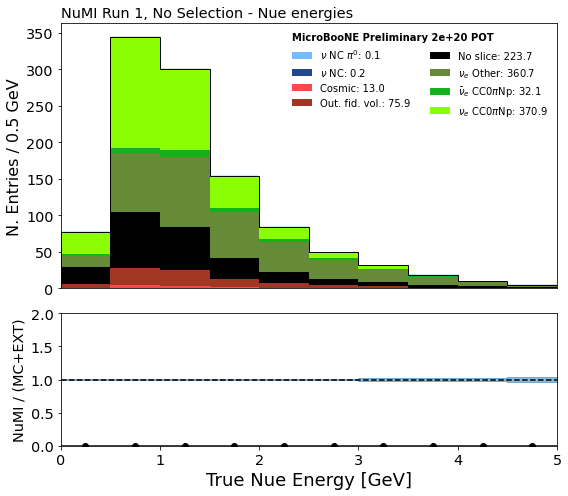

In [27]:
import matplotlib.pyplot as plt
import matplotlib

# DID YOU CHANGE BACK THE SYSTEMATICS???

VARIABLE, BINS, RANGE, XTIT = 'nu_e', 10, (0.0,5.0), r"True Nue Energy [GeV]"

#in the fiducial volume
fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and (abs(nu_pdg) == 12 and ccnc == 0)"
FID_QUERY = fiduc

#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= FID_QUERY ,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = False, # need this to plot MC!
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]


ax1.set_title('NuMI Run 1, No Selection - Nue energies',loc='left')
fig.tight_layout()
#fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTFinalFullMC/"+VARIABLE+"_varCV.pdf")
#print('%s %.4f %.4f %.4f ' % (VARIABLE, my_plotter.stats['pvalue'], my_plotter.stats['pvaluestatonly'],my_plotter.stats['pvaluediag'])+"\n")

/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:448: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


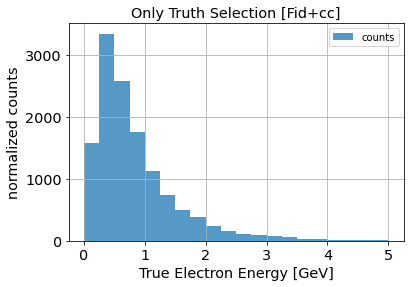

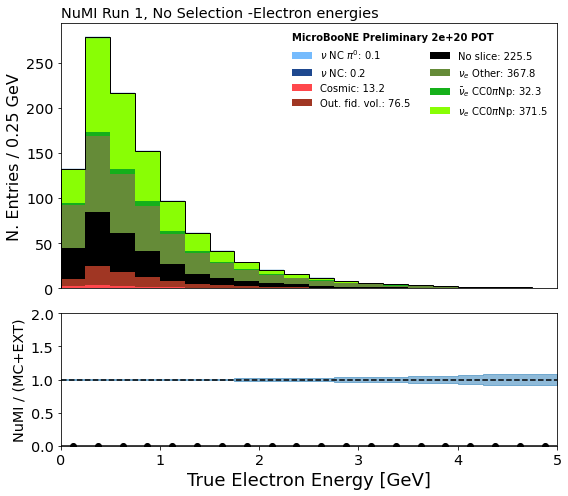

In [28]:
import matplotlib.pyplot as plt
import matplotlib

#in the fiducial volume
fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55"

#just look for electon neutrinos
q2 = "(abs(nu_pdg) == 12 and ccnc == 0) and " + fiduc
#in the mc data
nueMCSel  = mc.query(q2)

fig, ax = plt.subplots(nrows=1, sharex=True)

#n1, bins1, patches1 = ax[0].hist('elec_e',25,weights='weightSplineTimesTuneTimesPPFX',  range=(0,5), alpha=0.75, label='Elec')
n2, bins2, patches2 = ax.hist(nueMCSel['elec_e'],20,weights=nueMCSel['weightSplineTimesTuneTimesPPFX'],  range=(0,5), alpha=0.75, label='counts')

ax.set_xlabel('True Electron Energy [GeV]')
ax.set_ylabel('normalized counts')
ax.set_title('Only Truth Selection [Fid+cc]')
ax.legend()
ax.grid(True)

############################################

VARIABLE, BINS, RANGE, XTIT = 'elec_e', 20, (0.0,5.0), r"True Electron Energy [GeV]"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= FID_QUERY ,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = False, # need this to plot MC!
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, No Selection -Electron energies',loc='left')
fig.tight_layout()


### 1. Neutrino ID Selection plots. 

Required that there is a reconstructed neutrino interaction from Pandora consistent  with  a  flash  in-time  with  the  beam  window  and  that  the  event  contains  a reconstructed electromagnetic shower.

/home/amoor/miniconda3/envs/python3NuMIWS/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


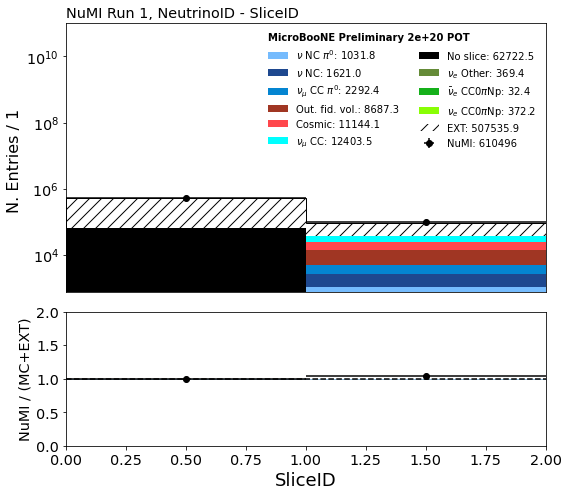

In [29]:
import matplotlib.pyplot as plt
import matplotlib

# DID YOU CHANGE BACK THE SYSTEMATICS???
SEL_QUERY = 'nslice >= 0'
VARIABLE, BINS, RANGE, XTIT = 'nslice', 2, (0.0,2.0), r"SliceID"
#VARIABLE, BINS, RANGE, XTIT = 'flash_time', 10, (0.0,10.0), r"Flash Time"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - SliceID',loc='left')
ax1.set_yscale("log")
ax1.set_ylim(0,10e10)
fig.tight_layout()
#fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/BDTFinalFullMC/"+VARIABLE+"_varCV.pdf")
#print('%s %.4f %.4f %.4f ' % (VARIABLE, my_plotter.stats['pvalue'], my_plotter.stats['pvaluestatonly'],my_plotter.stats['pvaluediag'])+"\n")

In [157]:
# from Katerina  - modified, to be able to plot truth mc with nue eff selections
# plot efficiency overlaid on selected signal events 
def plot_signal_and_eff(selected, df, signal, bins, truth): 
    
    # generated true signal events per bin 
    gen = plt.hist(df.query(signal)['nu_e'], bins, color='orange')
    plt.close()
    
    # plot selected signal events 
    fig, ax1 = plt.subplots(figsize=(4, 5))
    
    sel = ax1.hist(truth['nu_e'], bins, color='orange')
    ax1.set_ylabel('selected signal events', fontsize=15)
    ax1.set_xlabel('true nue energy [GeV]', fontsize=15)

    # compute efficiency
    #sel2=selected['nu_e']
    sel = ax1.hist(selected['nu_e'], bins, color='white')
    eff = [ a/b for a, b in zip(sel[0], gen[0]) ]
    eff_err = []
    for i in range(len(eff)):
        eff_err.append(math.sqrt( (eff[i]*(1-eff[i]))/gen[0][i] ) )
        
    # compute bin centers 
    bc = 0.5*(sel[1][1:]+sel[1][:-1])
    x_err = []
    for i in range(len(sel[1])-1): 
        x_err.append((sel[1][i+1]-sel[1][i])/2)

    # plot efficiency
    sel = ax1.hist(truth['nu_e'], bins, color='orange')
    ax1.set_ylim(0, 6000)
    ax2 = ax1.twinx()
    ax2.errorbar(bc, eff, xerr=x_err, yerr=eff_err, fmt='o', color='seagreen', ecolor='seagreen', markersize=3) 
    ax2.set_ylim(0, 1.00)
    ax2.set_ylabel('Efficiency', fontsize=15)
    ax2.set_title("Variable and Efficiency plot")

    plt.show()

100893 signal events were selected
126999  events were generated
efficiency =  0.7944393262939078
purity =  0.009068079518437107


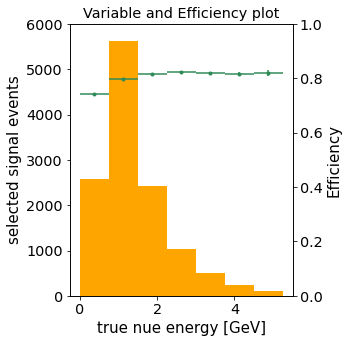

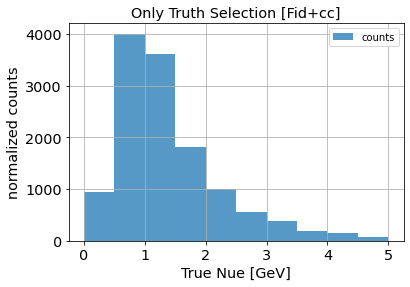

In [158]:
import matplotlib.pyplot as plt
import matplotlib
###########################################
#check the efficiency

#store efficiencies after each selection
effs = []
purs = []

#selCC = len(selected.query("is_signal"))
#totCC = len(nue.query("is_signal"))
#eff = selCC/totCC
#print("efficiency = ",eff)
effs.append(1.0)

#totfull = len(fullnue.query("is_signal"))
#print(totfull)
#pur = selCC/len(selected)
#print("purity = ", pur)
purs.append(0.0)

# signal topology: 1eNp 
SEL_QUERY = 'nslice == 1'
#SEL_QUERY = 'nslice == 1 and n_showers > 0 and reco_nu_vtx_sce_x > 8.45 and reco_nu_vtx_sce_x < 244.8 and reco_nu_vtx_sce_y > -106.5 and reco_nu_vtx_sce_y < 106.5 and reco_nu_vtx_sce_z > 5 and reco_nu_vtx_sce_z < 1031.8 and contained_fraction > 0.85 and (topological_score > 0.2 or topological_score < 0.01) and CosmicIPAll3D > 15 and shr_score < 0.15 and hits_ratio > 0.5 and shrmoliereavg < 7 and ((n_tracks > 0 and (((shr_tkfit_dedx_max > 0 and shr_tkfit_dedx_max < 1.75) and shr_distance <= 3)  or ((shr_tkfit_dedx_max >= 1.75 and shr_tkfit_dedx_max < 2.5) and shr_distance <= 12)  or ((shr_tkfit_dedx_max >= 2.5 and shr_tkfit_dedx_max < 3.5) and shr_distance <= 3) or ((shr_tkfit_dedx_max >= 3.5 and shr_tkfit_dedx_max < 4.7) and shr_distance <= 0) or ((shr_tkfit_dedx_max >= 4.7) and shr_distance <= 3))) or (n_tracks == 0 and ((shr_tkfit_dedx_max >= 1.7 and shr_tkfit_dedx_max < 2.7) or (shr_tkfit_dedx_max >= 5.5))))'

#selected = fullnue.query(SEL_QUERY)
selected = nue.query(SEL_QUERY)


fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and (abs(nu_pdg) == 12 and ccnc == 0)"

nueonly = "abs(nu_pdg) == 12"
nuecconly = "(abs(nu_pdg) == 12 and ccnc == 0)"

print(str(len(selected.query(fiduc_q)))+' signal events were selected')
print(str(len(nue.query(fiduc_q)))+'  events were generated')
selCC = len(selected.query(fiduc_q))
totCC = len(nue.query(fiduc_q))
eff = selCC/totCC                      #Selection eff = number of selected neutrino interactions
                                        #classified as either ν e / ̄ν e CC
                                        #divided by the total number 
                                        #of true simulated ν e and ν e CC interactions
                                        #in the fiducial volume
print("efficiency = ",eff)
effs.append(eff)

lnue = len(nue.query(SEL_QUERY)) * 0.008409085175623745
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057        #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.049246181662128984
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)              #Selection purity = number of selected neutrino interactions
                                    # classified as ν e / ̄ν e CC
                                    # divided by the total
                                    #number of selected events regardless their 
                                    #classification (but excluding the beam-on data)
purs.append(pur)



#bins = [0.25, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.05, 2.25, 2.45, 2.65, 2.85, 3.05]
bins = np.arange(0, 6.0, 0.75)
plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))

####################################
#in the fiducial volume
fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55"

#just look for electon neutrinos
q2 = "(abs(nu_pdg) == 12 and ccnc == 0) and +" + fiduc
#in the mc data
nueMCSel  = mc.query(q2)

fig, ax = plt.subplots(nrows=1, sharex=True)

#n1, bins1, patches1 = ax[0].hist('elec_e',25,weights='weightSplineTimesTuneTimesPPFX',  range=(0,5), alpha=0.75, label='Elec')
n2, bins2, patches2 = ax.hist(nueMCSel['nu_e'],10,weights=nueMCSel['weightSplineTimesTuneTimesPPFX'],  range=(0,5), alpha=0.75, label='counts')

ax.set_xlabel('True Nue [GeV]')
ax.set_ylabel('normalized counts')
ax.set_title('Only Truth Selection [Fid+cc]')
ax.legend()
ax.grid(True)

nslice == 1


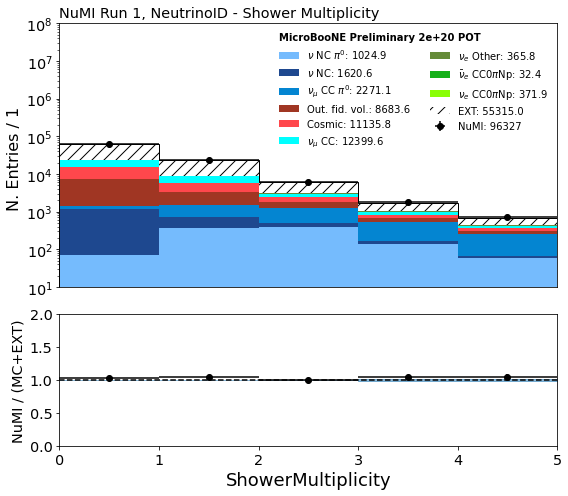

In [32]:
##Now shower multiplicity

VARIABLE, BINS, RANGE, XTIT = 'n_showers', 5, (0.0,5.0), r"ShowerMultiplicity"

print(SEL_QUERY)

#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - Shower Multiplicity',loc='left')
ax1.set_yscale("log")
ax1.set_ylim(10e0,10e7)
fig.tight_layout()

######################################################

In [159]:
SEL_QUERY += ' and n_showers > 0'
selected = nue.query(SEL_QUERY)

selCC = len(selected.query(fiduc_q))
totCC = len(nue.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)

lnue = len(nue.query(SEL_QUERY)) * 0.008409085175623745
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057        #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.049246181662128984
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)
purs.append(pur)

efficiency =  0.7175568311561509
purity =  0.02401013227294857


### 2. Containment

Plots of the reconstructed vertex position in x, y, and z, before any volume cuts applied. Plot of the contained fraction (hits in FV/hits in slice) of hits before selection cut applied. Plot of contained fraction efficiency as a function of true neutrino energy.

nslice == 1 and n_showers > 0


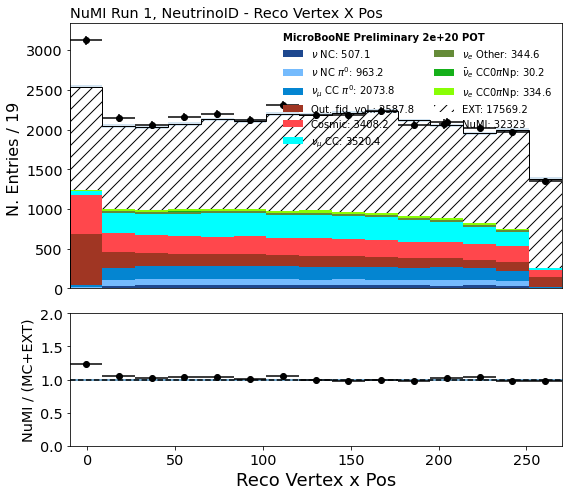

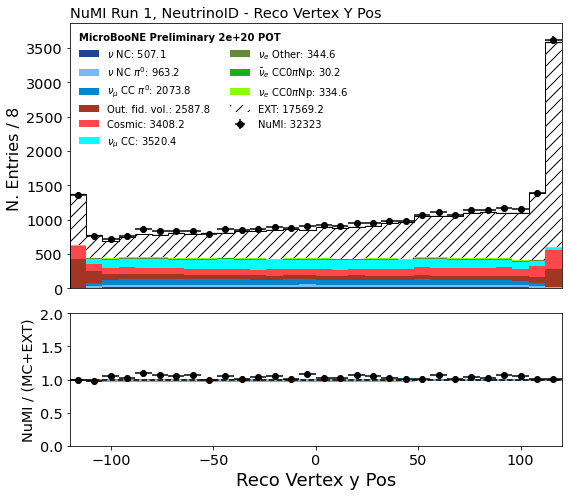

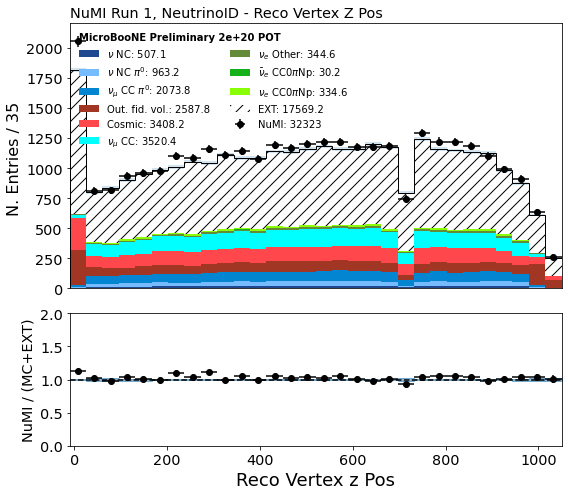

In [34]:
# Reconstructed vertex position plots
#X

print(SEL_QUERY)
#SEL_QUERYA = SEL_QUERY
#SEL_QUERYA = "reco_nu_vtx_sce_x >= 0 and n_showers_contained > 0 and nslice == 1"


VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x', 15, (-10.0,270.0), r"Reco Vertex x Pos"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - Reco Vertex X Pos',loc='left')
fig.tight_layout()

################################################
#Y

VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y', 30, (-120.0,120.0), r"Reco Vertex y Pos"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - Reco Vertex Y Pos',loc='left')
fig.tight_layout()

################################################
#Z

VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z', 30, (-10.0,1050.0), r"Reco Vertex z Pos"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - Reco Vertex Z Pos',loc='left')
fig.tight_layout()

###########################################

In [160]:
SEL_QUERY += ' and reco_nu_vtx_sce_x > 8.45 and reco_nu_vtx_sce_x < 244.8 and reco_nu_vtx_sce_y > -106.5 and reco_nu_vtx_sce_y < 106.5 and reco_nu_vtx_sce_z > 5 and reco_nu_vtx_sce_z < 1031.8'
selected = nue.query(SEL_QUERY)

selCC = len(selected.query(fiduc_q))
totCC = len(nue.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)

lnue = len(nue.query(SEL_QUERY)) * 0.008409085175623745
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057        #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.049246181662128984
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)
purs.append(pur)

efficiency =  0.6253907511082765
purity =  0.03472776876080503


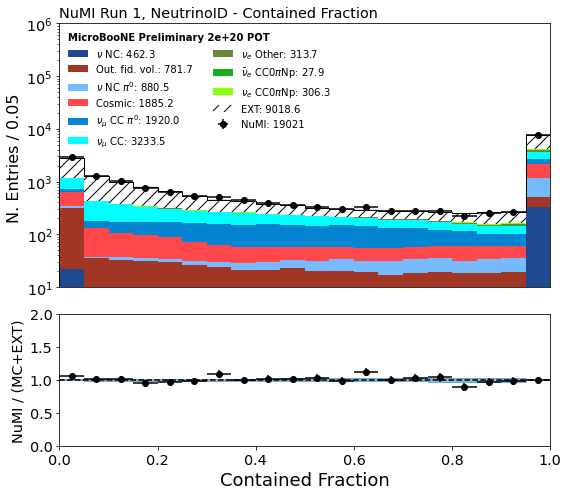

In [36]:
# Now for containment fraction

#print(SEL_QUERY)

VARIABLE, BINS, RANGE, XTIT = 'contained_fraction', 20, (0.0,1.0), r"Contained Fraction"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - Contained Fraction',loc='left')
ax1.set_yscale("log")
ax1.set_ylim(10e0,10e5)
fig.tight_layout()

64499 signal events were selected
126999 signal events were generated
efficiency =  0.5078701407097693
purity =  0.06447037491622772


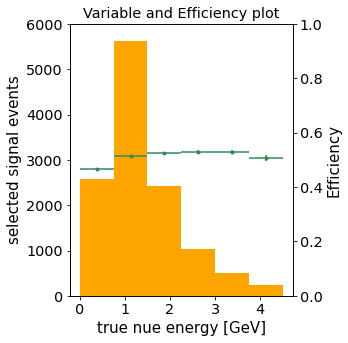

In [161]:
## Now contained fraction/efficiency as a function of true nue energy

#fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55"

# FV cut 
#SEL_QUERY = fiduc

# signal topology: 1eNp 
SEL_QUERY += ' and contained_fraction > 0.85'
selected = nue.query(SEL_QUERY)

#print(SEL_QUERY)
print(str(len(selected.query(fiduc_q)))+' signal events were selected')
print(str(len(nue.query(fiduc_q)))+' signal events were generated')

selCC = len(selected.query(fiduc_q))
totCC = len(nue.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)

lnue = len(nue.query(SEL_QUERY)) * 0.008409085175623745
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057        #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.049246181662128984
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)
purs.append(pur)

#bins = [0.25, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.05, 2.25, 2.45, 2.65, 2.85, 3.05]
bins = np.arange(0, 5.0, 0.75)
plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))

### 3. Cosmic Rejection

Plot of Pandora topological score before selection is applied (+ on a log scale?). Plot of Cosmic Impact Parameter variable. Plot of CIP/efficiency as a function of true neutrino energy.

nslice == 1 and n_showers > 0 and reco_nu_vtx_sce_x > 8.45 and reco_nu_vtx_sce_x < 244.8 and reco_nu_vtx_sce_y > -106.5 and reco_nu_vtx_sce_y < 106.5 and reco_nu_vtx_sce_z > 5 and reco_nu_vtx_sce_z < 1031.8 and contained_fraction > 0.85


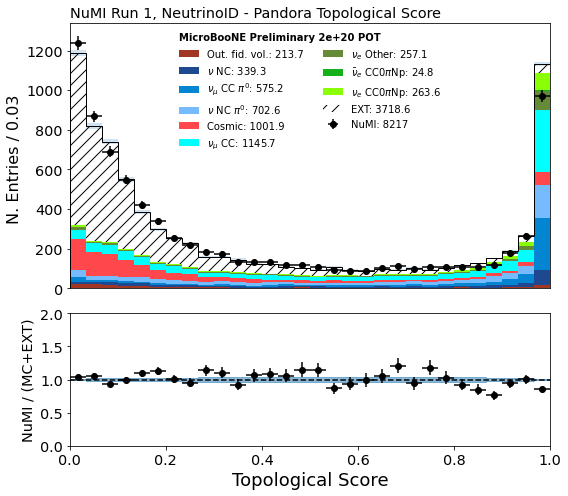

In [38]:
#topological score

VARIABLE, BINS, RANGE, XTIT = 'topological_score', 30, (0.0,1.0), r"Topological Score"

print(SEL_QUERY)
#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - Pandora Topological Score',loc='left')
fig.tight_layout()

efficiency =  0.4477043126323829
purity =  0.09711121881051726


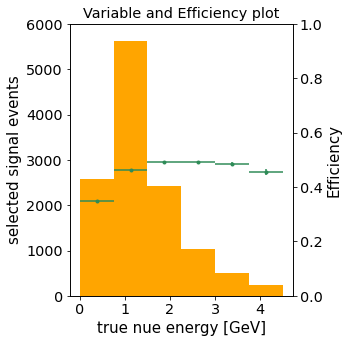

In [162]:
SEL_QUERY += ' and (topological_score > 0.2 or topological_score < 0.01)'
selected = nue.query(SEL_QUERY)
#print(SEL_QUERY)

selCC = len(selected.query(fiduc_q))
totCC = len(nue.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)

lnue = len(nue.query(SEL_QUERY)) * 0.008409085175623745
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057        #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.049246181662128984
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)
purs.append(pur)

#bins = [0.25, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.05, 2.25, 2.45, 2.65, 2.85, 3.05]
bins = np.arange(0, 5.0, 0.75)
plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))

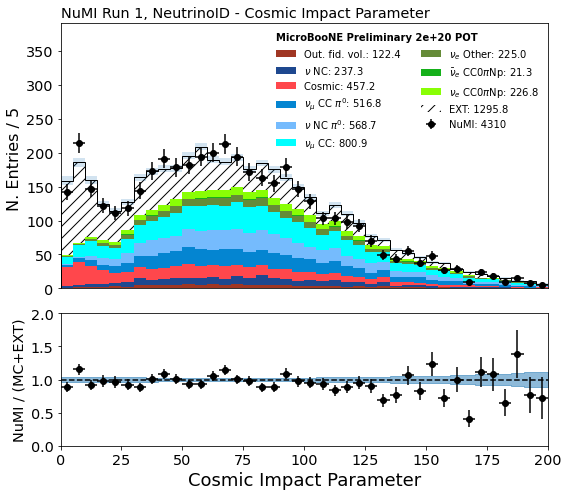

In [40]:
#now Cosmic Impact Parameter


VARIABLE, BINS, RANGE, XTIT = 'CosmicIPAll3D', 40, (0.0,200.0), r"Cosmic Impact Parameter"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - Cosmic Impact Parameter',loc='left')
ax1.set_ylim(0,390)
fig.tight_layout()

55388 signal events were selected
126999 signal events were generated
efficiency =  0.4361294183418767
purity =  0.10545747429895654


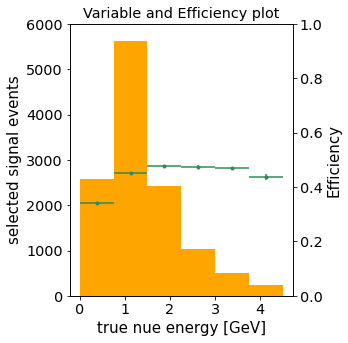

In [163]:
SEL_QUERY += ' and CosmicIPAll3D > 15'
selected = nue.query(SEL_QUERY)

#print(SEL_QUERY)
print(str(len(selected.query(fiduc_q)))+' signal events were selected')
print(str(len(nue.query(fiduc_q)))+' signal events were generated')

selCC = len(selected.query(fiduc_q))
totCC = len(nue.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)


lnue = len(nue.query(SEL_QUERY)) * 0.008409085175623745
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057        #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.049246181662128984
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)
purs.append(pur)

#bins = [0.25, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.05, 2.25, 2.45, 2.65, 2.85, 3.05]
bins = np.arange(0, 5.0, 0.75)
plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))

### 4. Shower ID

Plot of Pandora Shower Score Variable before selection is applied. Plot of hit ratio (shower/slice) before selection applied. Plot of hit ratio efficiency as a function of true neutrino energy.

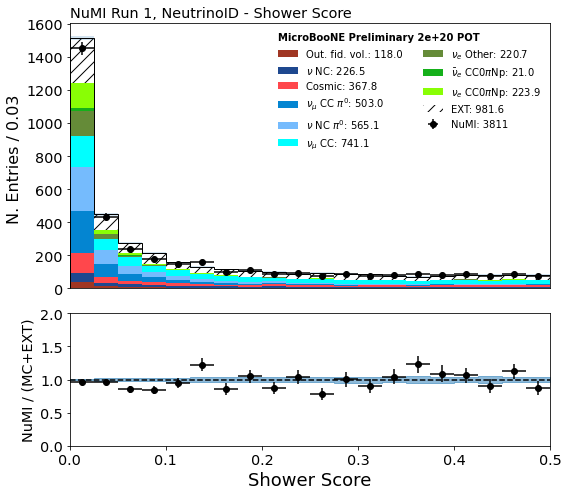

In [42]:
#shower score

#print(SEL_QUERY)

VARIABLE, BINS, RANGE, XTIT = 'shr_score', 20, (0.0,0.5), r"Shower Score"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - Shower Score',loc='left')
fig.tight_layout()

In [164]:
SEL_QUERY += ' and shr_score < 0.15'
selected = nue.query(SEL_QUERY)
#print(SEL_QUERY)

selCC = len(selected.query(fiduc_q))
totCC = len(nue.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)

lnue = len(nue.query(SEL_QUERY)) * 0.008409085175623745
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057        #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.049246181662128984
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)
purs.append(pur)

efficiency =  0.4016173355695714
purity =  0.13590903016401645


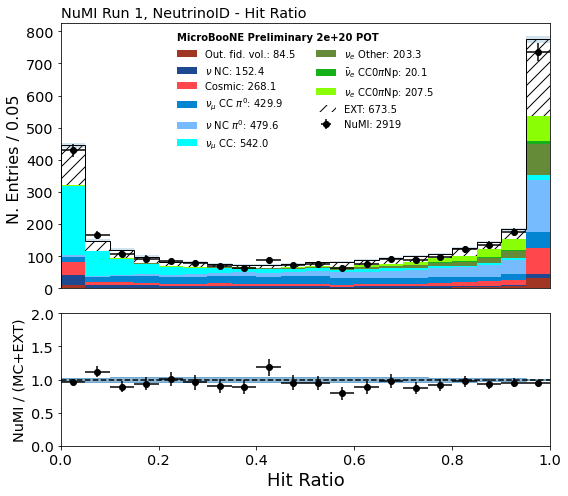

In [44]:
#Hit ratio

VARIABLE, BINS, RANGE, XTIT = 'hits_ratio', 20, (0.0,1.0), r"Hit Ratio"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - Hit Ratio',loc='left')
fig.tight_layout()

47583 signal events were selected
126999 signal events were generated
efficiency =  0.3746722415137127
purity =  0.21767300100928288


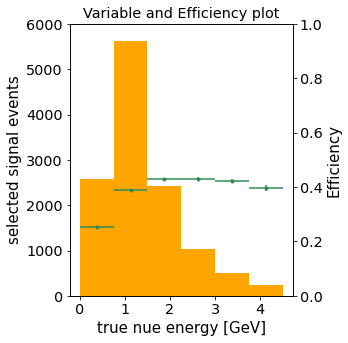

In [165]:
SEL_QUERY += ' and hits_ratio > 0.5'
selected = nue.query(SEL_QUERY)

#print(SEL_QUERY)
print(str(len(selected.query(fiduc_q)))+' signal events were selected')
print(str(len(nue.query(fiduc_q)))+' signal events were generated')

selCC = len(selected.query(fiduc_q))
totCC = len(nue.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)

lnue = len(nue.query(SEL_QUERY)) * 0.008409085175623745
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057        #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.049246181662128984
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)
purs.append(pur)

#bins = [0.25, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.05, 2.25, 2.45, 2.65, 2.85, 3.05]
bins = np.arange(0, 5.0, 0.75)
plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))

### 5. Electron-Photon Separation

Plot of Moliere Average. Plots of shower to vertex distence and leading shower dEdx (+combined?). Plot of dEdx max variable for the case of no tracks. Plot of dEdx no tracks/efficiency as a function of true energy. 

IN COVMATRIX_XS_PPFX
Universes 500
Universes 500
Universes 500
Add Drawing Geo Sys
Number of variations Universes 10
draw Sys


/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:448: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:256: RuntimeWarning: divide by zero encountered in true_divide
  return (data-mc)**2 / data


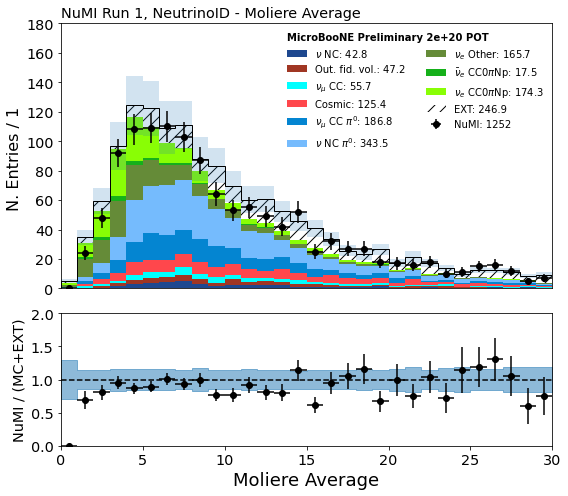

In [46]:
## Moliere Angle
#print(SEL_QUERY)

VARIABLE, BINS, RANGE, XTIT = 'shrmoliereavg', 30, (0.0,30.0), r"Moliere Average"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = True, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - Moliere Average',loc='left')
ax1.set_ylim(0,180)
fig.tight_layout()

In [166]:
SEL_QUERY += ' and shrmoliereavg < 7'
selected = nue.query(SEL_QUERY)
#print(SEL_QUERY)

selCC = len(selected.query(fiduc_q))
totCC = len(nue.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)

lnue = len(nue.query(SEL_QUERY)) * 0.008409085175623745
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057        #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.049246181662128984
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)
purs.append(pur)

efficiency =  0.2557815415869416
purity =  0.3574303217695305


nslice == 1 and n_showers > 0 and reco_nu_vtx_sce_x > 8.45 and reco_nu_vtx_sce_x < 244.8 and reco_nu_vtx_sce_y > -106.5 and reco_nu_vtx_sce_y < 106.5 and reco_nu_vtx_sce_z > 5 and reco_nu_vtx_sce_z < 1031.8 and contained_fraction > 0.85 and (topological_score > 0.2 or topological_score < 0.01) and CosmicIPAll3D > 15 and shr_score < 0.15 and hits_ratio > 0.5 and shrmoliereavg < 7


/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:448: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


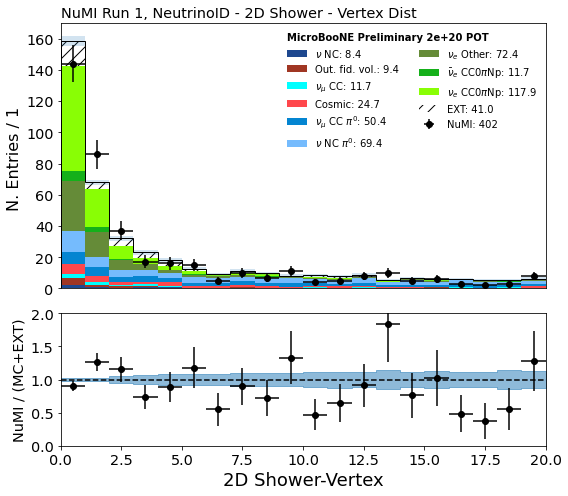

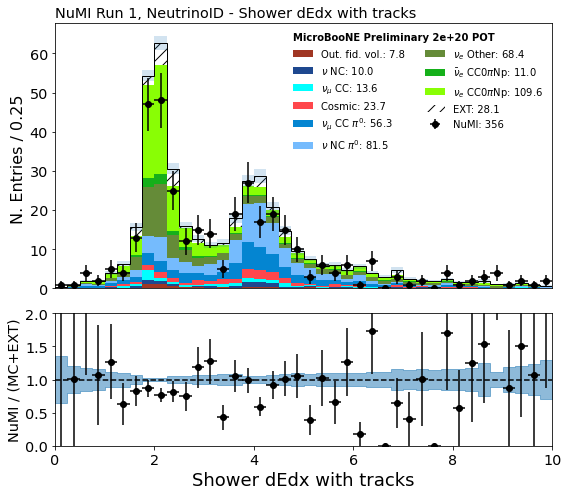

In [48]:
#2D shower-vertex distence and shower dE/dx (with tracks)

print(SEL_QUERY)
#2D shower-vertex distence
QUERY_T = SEL_QUERY + ' and n_tracks > 0'

VARIABLE, BINS, RANGE, XTIT = 'shr_distance', 20, (0.0,20.0), r"2D Shower-Vertex"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY_T,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - 2D Shower - Vertex Dist',loc='left')
fig.tight_layout()

#######################################################

#shower dEdx with tracks
VARIABLE, BINS, RANGE, XTIT = 'shr_tkfit_dedx_max', 40, (0.0,10.0), r"Shower dEdx with tracks"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY_T,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = False, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - Shower dEdx with tracks',loc='left')
fig.tight_layout()

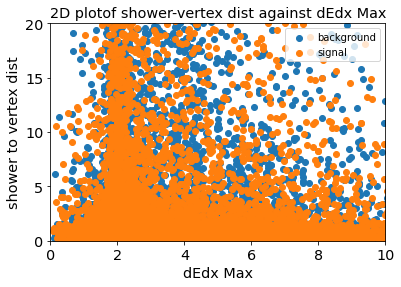

In [49]:
#plot the two against eachother
#not....not like that....maybe will look better in full?

#can plot one for signal, one for background, and overlay them

selected = nue.query(QUERY_T)

#print(SEL_QUERY)
#print(str(len(selected.query("is_signal")))+' signal events were selected')
#print(str(len(nue.query("is_signal")))+' signal events were generated')

#print(str(len(nue.query("is_not_signal")))+' background events were generated')

plt.scatter(selected.query("is_not_signal")['shr_tkfit_dedx_max'], selected.query("is_not_signal")['shr_distance'])
plt.scatter(selected.query("is_signal")['shr_tkfit_dedx_max'], selected.query("is_signal")['shr_distance'])
plt.ylabel("shower to vertex dist")
plt.xlabel("dEdx Max")
plt.title("2D plotof shower-vertex dist against dEdx Max")
plt.xlim([0, 10])
plt.ylim([0, 20])
plt.legend(["background", "signal"])
plt.show()


In [52]:
#now need to add the 2D selection to the QUERY

#SEL_QUERY += ' and (((shr_tkfit_dedx_max > 0 and shr_tkfit_dedx_max < 1.75) and shr_distance < 3) \
 #or ((shr_tkfit_dedx_max > 1.75 and shr_tkfit_dedx_max < 2.5) and shr_distance < 12) \
 #or ((shr_tkfit_dedx_max > 2.5 and shr_tkfit_dedx_max < 3.5) and shr_distance < 3)\
 #or ((shr_tkfit_dedx_max > 4.7) and shr_distance < 3))'
#print(SEL_QUERY)
#selected = nue.query(SEL_QUERY)

#selCC = len(selected.query("is_signal"))
#totCC = len(nue.query("is_signal"))
#eff = selCC/totCC
#print("efficiency = ",eff)
#effs.append(eff)

#pur = selCC/len(selected)
#print("purity = ", pur)
#purs.append(pur)

#think need to do this with the no tracks one?

IN COVMATRIX_XS_PPFX
Universes 500
Universes 500
Universes 500
Add Drawing Geo Sys
Number of variations Universes 10
draw Sys


/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:448: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:256: RuntimeWarning: divide by zero encountered in true_divide
  return (data-mc)**2 / data


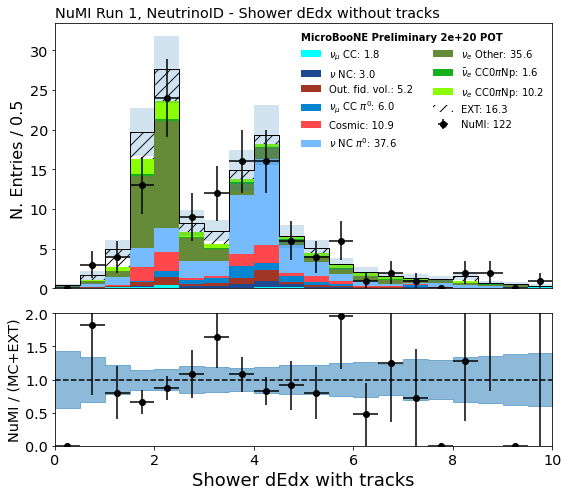

In [50]:
# plot dEdx no tracks
#TRACKS, not SHOWERS
QUERY_NT = SEL_QUERY + ' and n_tracks == 0' #none of these left? Will break

VARIABLE, BINS, RANGE, XTIT = 'shr_tkfit_dedx_max', 20, (0.0, 10.0), r"Shower dEdx with tracks"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY_NT,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = True, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - Shower dEdx without tracks',loc='left')
fig.tight_layout()

nslice == 1 and n_showers > 0 and reco_nu_vtx_sce_x > 8.45 and reco_nu_vtx_sce_x < 244.8 and reco_nu_vtx_sce_y > -106.5 and reco_nu_vtx_sce_y < 106.5 and reco_nu_vtx_sce_z > 5 and reco_nu_vtx_sce_z < 1031.8 and contained_fraction > 0.85 and (topological_score > 0.2 or topological_score < 0.01) and CosmicIPAll3D > 15 and shr_score < 0.15 and hits_ratio > 0.5 and shrmoliereavg < 7 and ((n_tracks > 0 and (((shr_tkfit_dedx_max > 0 and shr_tkfit_dedx_max < 1.75) and shr_distance <= 3)  or ((shr_tkfit_dedx_max >= 1.75 and shr_tkfit_dedx_max < 2.5) and shr_distance <= 12)  or ((shr_tkfit_dedx_max >= 2.5 and shr_tkfit_dedx_max < 3.5) and shr_distance <= 3) or ((shr_tkfit_dedx_max >= 3.5 and shr_tkfit_dedx_max < 4.7) and shr_distance <= 0) or ((shr_tkfit_dedx_max >= 4.7) and shr_distance <= 3))) or (n_tracks == 0 and ((shr_tkfit_dedx_max >= 1.7 and shr_tkfit_dedx_max < 2.7) or (shr_tkfit_dedx_max >= 5.5))))
21577 signal events were selected
126999 signal events were generated
efficiency =  0.16

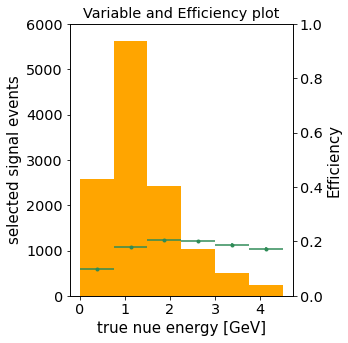

In [167]:
SEL_QUERY += ' and ((n_tracks > 0 and (((shr_tkfit_dedx_max > 0 and shr_tkfit_dedx_max < 1.75) and shr_distance <= 3) \
 or ((shr_tkfit_dedx_max >= 1.75 and shr_tkfit_dedx_max < 2.5) and shr_distance <= 12) \
 or ((shr_tkfit_dedx_max >= 2.5 and shr_tkfit_dedx_max < 3.5) and shr_distance <= 3)\
 or ((shr_tkfit_dedx_max >= 3.5 and shr_tkfit_dedx_max < 4.7) and shr_distance <= 0)\
 or ((shr_tkfit_dedx_max >= 4.7) and shr_distance <= 3))) or (n_tracks == 0 and\
 ((shr_tkfit_dedx_max >= 1.7 and shr_tkfit_dedx_max < 2.7) or (shr_tkfit_dedx_max >= 5.5))))'

selected = nue.query(SEL_QUERY)

print(SEL_QUERY)

print(str(len(selected.query(fiduc_q)))+' signal events were selected')
print(str(len(nue.query(fiduc_q)))+' signal events were generated')

selCC = len(selected.query(fiduc_q))
totCC = len(nue.query(fiduc_q))
eff = selCC/totCC
print("efficiency = ",eff)
effs.append(eff)


lnue = len(nue.query(SEL_QUERY)) * 0.008409085175623745
lmc = len(mc.query(SEL_QUERY))* 0.08559738414394057        #true signal + background in volume
ldirt = len(dirt.query(SEL_QUERY)) * 0.049246181662128984
lext = len(ext.query(SEL_QUERY))* 0.5612087579382191
pur = lnue/(lmc+ldirt+lext)

print("purity = ", pur)
purs.append(pur)


bins = np.arange(0, 5.0, 0.75)
plot_signal_and_eff(selected, nue, fiduc_q, bins, mc.query(fiduc_q))

## Purity and Efficiency

Selection Efficiency = no. reconstructed neutrinos classified as nue CC that pass selection / total number of these simulated in the fiducial volume.

Selection Purity = no. reconstructed neutrinos classified as nue CC that pass selection / total number of selected neutrinos in any classification.

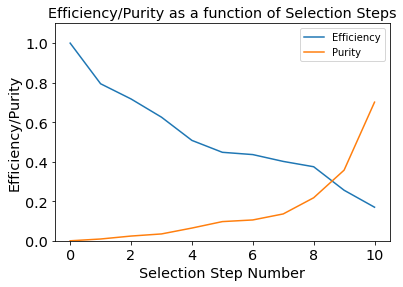

In [156]:
#make an efficiency/purity plot for each of the selection steps

plt.plot(effs)
plt.plot(purs)
plt.title("Efficiency/Purity as a function of Selection Steps")
plt.xlabel("Selection Step Number")
plt.ylabel("Efficiency/Purity")
plt.ylim([0,1.1])
plt.legend(["Efficiency", "Purity"])
plt.show()

IN COVMATRIX_XS_PPFX
Universes 500
Universes 500
Universes 500
Add Drawing Geo Sys
Number of variations Universes 10
draw Sys


/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:448: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:256: RuntimeWarning: divide by zero encountered in true_divide
  return (data-mc)**2 / data


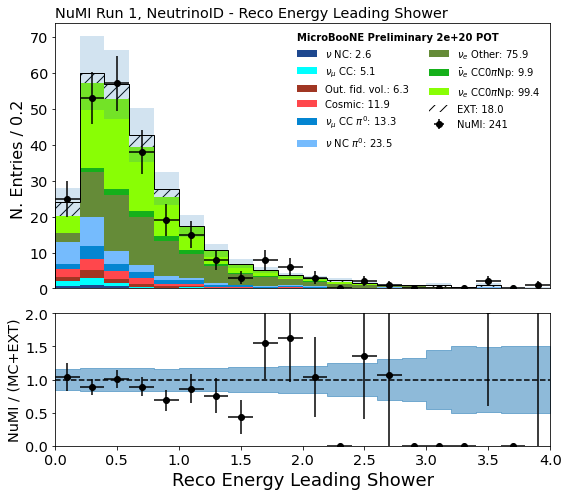

In [114]:
#df_v = [nue]
#for i,df in enumerate(df_v):
#    df.loc[ (df['shr_energy_cali']), 'shr_energy_cali' ] = /0.83

# plot dEdx no tracks
QUERY_NT = SEL_QUERY

VARIABLE, BINS, RANGE, XTIT = 'shr_energy_cali', 20, (0.0, 4.0), r"Reco Energy Leading Shower"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY_NT,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = True, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - Reco Energy Leading Shower',loc='left')
fig.tight_layout()

IN COVMATRIX_XS_PPFX
Universes 500
Universes 500
Universes 500
Add Drawing Geo Sys
Number of variations Universes 10
draw Sys


/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:256: RuntimeWarning: invalid value encountered in true_divide
  return (data-mc)**2 / data
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:252: RuntimeWarning: invalid value encountered in true_divide
  return (data-mc)**2 / mc
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:246: RuntimeWarning: invalid value encountered in true_divide
  return sum(num / den) / len(data)
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:2157: RuntimeWarning: invalid value encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


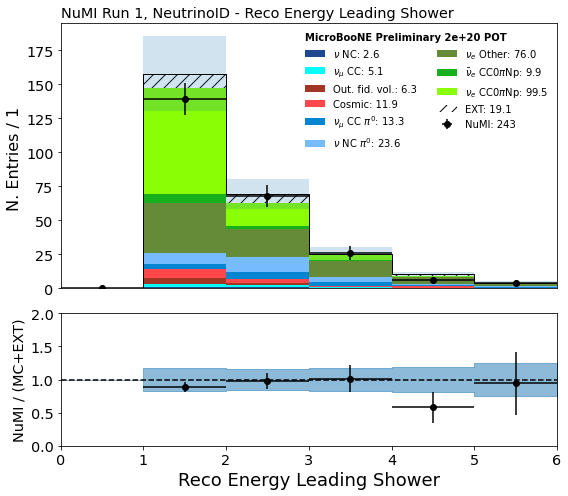

In [115]:
# plot dEdx no tracks
QUERY_NT = SEL_QUERY

VARIABLE, BINS, RANGE, XTIT = 'n_showers', 6, (0.0, 6.0), r"Reco Energy Leading Shower"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY_NT,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = True, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - Reco Energy Leading Shower',loc='left')
fig.tight_layout()

nslice == 1 and n_showers > 0 and reco_nu_vtx_sce_x > 8.45 and reco_nu_vtx_sce_x < 244.8 and reco_nu_vtx_sce_y > -106.5 and reco_nu_vtx_sce_y < 106.5 and reco_nu_vtx_sce_z > 5 and reco_nu_vtx_sce_z < 1031.8 and contained_fraction > 0.85 and (topological_score > 0.2 or topological_score < 0.01) and CosmicIPAll3D > 15 and shr_score < 0.15 and hits_ratio > 0.5 and shrmoliereavg < 7 and ((n_tracks > 0 and (((shr_tkfit_dedx_max > 0 and shr_tkfit_dedx_max < 1.75) and shr_distance <= 3)  or ((shr_tkfit_dedx_max >= 1.75 and shr_tkfit_dedx_max < 2.5) and shr_distance <= 12)  or ((shr_tkfit_dedx_max >= 2.5 and shr_tkfit_dedx_max < 3.5) and shr_distance <= 3) or ((shr_tkfit_dedx_max >= 3.5 and shr_tkfit_dedx_max < 4.7) and shr_distance <= 0) or ((shr_tkfit_dedx_max >= 4.7) and shr_distance <= 3))) or (n_tracks == 0 and ((shr_tkfit_dedx_max >= 1.7 and shr_tkfit_dedx_max < 2.7) or (shr_tkfit_dedx_max >= 5.5))))
IN COVMATRIX_XS_PPFX
Universes 500
Universes 500
Universes 500
Add Drawing Geo Sys
Numbe

/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:448: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:256: RuntimeWarning: divide by zero encountered in true_divide
  return (data-mc)**2 / data
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:256: RuntimeWarning: invalid value encountered in true_divide
  return (data-mc)**2 / data
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:252: RuntimeWarning: invalid value encountered in true_divide
  return (data-mc)**2 / mc
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:246: RuntimeWarning: invalid value encountered in true_divide
  return sum(num / den) / len(data)
/home/amoor/NuMI/NuMI_Analysis/PELEE/plotter.py:2157: RuntimeWarning: invalid value encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


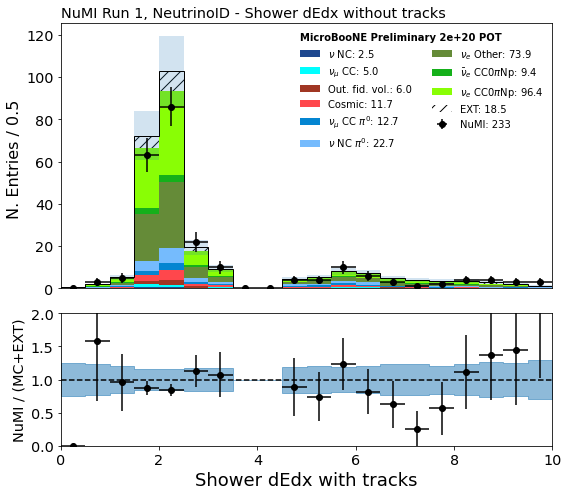

In [116]:
# plot dEdx no tracks
#TRACKS, not SHOWERS
QUERY_NT = SEL_QUERY #none of these left? Will break
print(SEL_QUERY)

VARIABLE, BINS, RANGE, XTIT = 'shr_tkfit_dedx_max', 20, (0.0, 10.0), r"Shower dEdx with tracks"


#This is the making of the actual plot
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY_NT,
    kind="event_category", # this splits up the MC in many physics categories
    draw_sys  = True, # We plot the PPFX, GENIE and ReInteraction Systematics (the other systematics are to be implemented)
    draw_data = True,
    draw_geoSys = True, 
    genieweight = "weightSplineTimesTuneTimesPPFX", # This is the official weight we calculated before. 
    stacksort=3, # order of categories
    title=XTIT, # Name of X axis
    bins=BINS,
    range=RANGE,
)[0:3]

#ax1.set_title('NuMI Run 1, 1eNp Final Sel -- Nue Intrinsic --  HP,XSec,G4 Syst',loc='left')
ax1.set_title('NuMI Run 1, NeutrinoID - Shower dEdx without tracks',loc='left')
fig.tight_layout()